In [1]:
import chem_ocean.ocean_plt as oc_plt
import chem_ocean.ocean_analysis as oc_an

from chem_ocean import ocean_data as oc_data
from chem_ocean.ocean_plt_util import make_section, subplot_labels, save_name

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from scipy import stats
title_sz = 27
axis_sz = 22
tick_sz = 21

%matplotlib inline

In [3]:
path = 'raw_demo_plots/'

In [4]:
minlat, minlon = -40, -30
_x, _y, _d, _feat_data, _basemap, _xLab, _yLab, _latLon_params = oc_data.get_column([minlat, minlat+2], [minlon, minlon+2], ['nitrate'])

0.23725008964538574


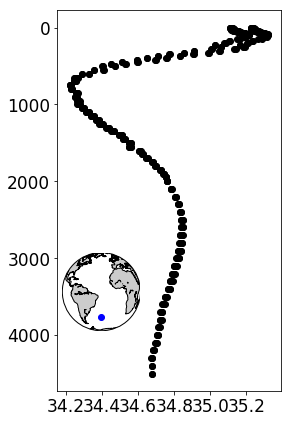

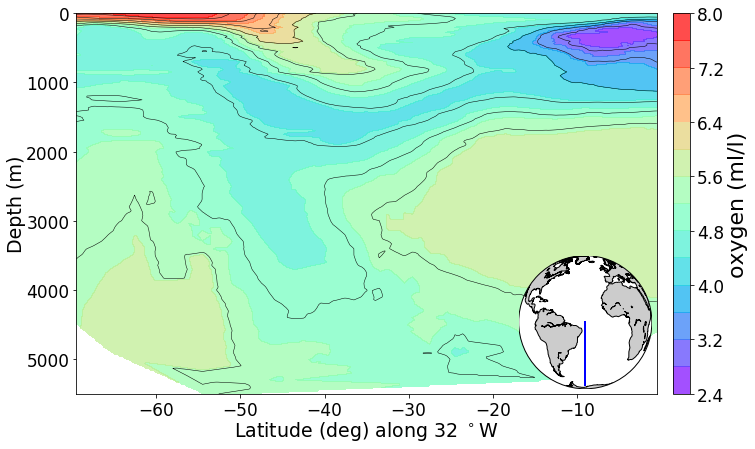

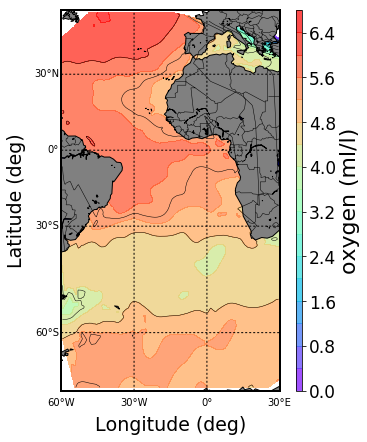

In [10]:
minlat, minlon = -40, -30
fig, (ax1) = oc_plt.plotRaw(minlat, minlat+2, minlon, minlon+2, ['salinity'], 'column')
# plt.savefig(path+'nitrate_column_40s30w.png', dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None)

fig, (ax1) = oc_plt.plotRaw(-70, 0, -32, -32, ['oxygen'], 'NS_section')
# plt.savefig(path+'nitrate_section_70-0s32w.png', dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None)

fig, (ax1) = oc_plt.plotRaw(-90, 90, -180, 180, ['phostphate'], 'plan', depth = 25, plot_pt = (68.5, -99.5)
# plt.savefig(path+'nitrate_plan_70s-50n_60w-30e_2000m.png', dpi=None, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None)

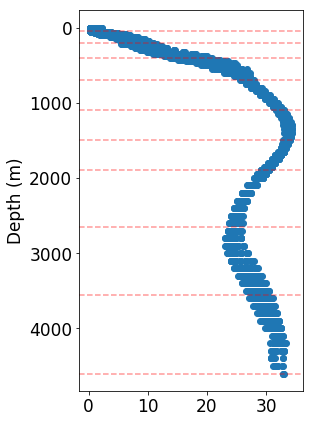

In [4]:
_x, _y, _d, _feat_data, _basemap, _xLab, _yLab, _latLon_params = oc_data.get_column([-40, -35], [-30, -25], ['nitrate'])
intervals, fig, ax =oc_an.column_split_ptest(_feat_data, _d)

In [6]:
ptlat = -43.5
ptlon = -32

tracer = 'salinity'
minlat, maxlat, minlon, maxlon = -70, 0, -32, -32
slice_type = 'NS_section'
dpth = 1950

0.10109210014343262


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


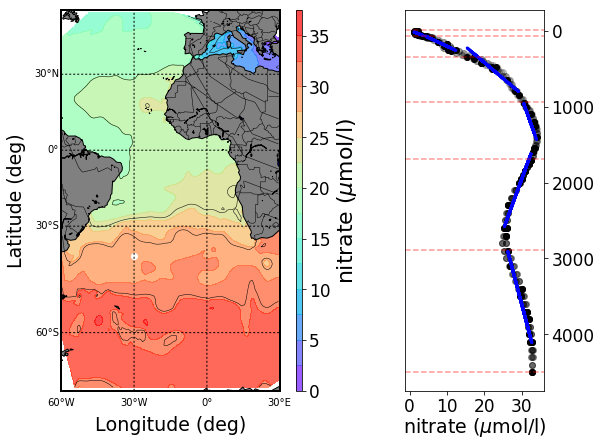

In [10]:
fig, (ax1, ax2) = oc_plt.plotRaw(-70, 50, -60, 30, ['nitrate'], 'plan', depth = 2000, add_profile = True, plot_pt = (minlat, minlon))
intervals, fig, ax2 = oc_an.column_split_byslope(_feat_data, _d, exist_plt = (fig, ax2))#, depth_lim = (min(_d), max(_d)))

In [6]:
ptlat = 43.5
ptlon = 39.5

tracer = 'phosphate'
minlat, maxlat, minlon, maxlon = -70, 70,-180, 180
slice_type = 'plan'
dpth = 1950

0.4293389320373535


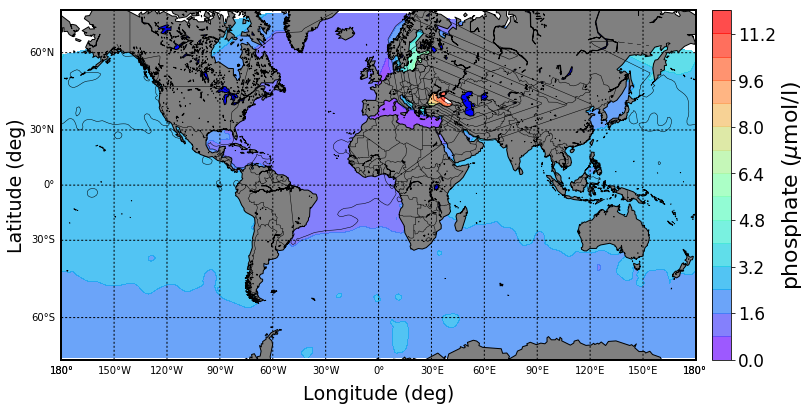

In [5]:
name1 = save_name(tracer, slice_type, minlat, maxlat, minlon, maxlon, depth = dpth)

fig, (ax1) = oc_plt.plotRaw(minlat, maxlat, minlon, maxlon, [tracer], slice_type, depth = dpth, plot_pt = (ptlat, ptlon))

plt.savefig(path+name1+'.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)

print(name1)

The work below is to alter plot_raw to accomodate 2 figures more generically

In [1]:
from matplotlib.mlab import griddata
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import cm, rcParams

import numpy as np

from mpl_toolkits.basemap import Basemap, shiftgrid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

title_sz = 27
axis_sz = 22
tick_sz = 21

import chem_ocean.ocean_data as oc_data

rcParams.update({'font.size': tick_sz-4}) # Increase font-size
# from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.cm as cm

from mpl_toolkits.basemap import Basemap, shiftgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import numpy as np
from numpy import linspace
from numpy import meshgrid

import pylab as pl
from collections import defaultdict

import chem_ocean.Build_Map as bm
from chem_ocean.ocean_plt_util import make_section, subplot_labels

In [2]:
import sqlalchemy
from collections import defaultdict

In [9]:
class getData():
    
    def __init__(self):
        self._x = None
        self._y = None
        self._d = None
        self._feat_data = None
        self.cluster_d = None
        self._xLab = None
        self._yLab = None
        self._lonLat_params = None
        
    
    def connect(self, user, password, db, host='localhost', port=5432):
        '''Returns a connection and a metadata object'''
        url  = 'postgresql://{}:{}@{}:{}/{}'
        url = url.format(user, password, host, port, db)

        # The return value of create_engine() is our connection object
        con = sqlalchemy.create_engine(url, client_encoding='utf8')

        # We then bind the connection to MetaData()
        meta = sqlalchemy.MetaData(bind=con, reflect=True)

        return con, meta, url
    
    def return_from_psql(self, query, cols, _in_var_names, _x_var, _y_var, **kwargs):
        conn, meta, url = self.connect('jlanders', '', 'odv_app_dev', host='localhost', port=5432)
        result = conn.execute(query)

        cluster_d = defaultdict(list)
        for row in result:
            for ik, col in enumerate(cols):
                cluster_d[col].append(row[ik])
        _x = np.asarray(cluster_d[_x_var])
        _y = np.asarray(cluster_d[_y_var])
        _d = np.asarray(cluster_d['depth'])

        _feat_data = np.zeros((len(_x), len(_in_var_names))) 
        for ik, name in enumerate(_in_var_names):
            _feat_data[:, ik] = np.asarray(cluster_d[name])

        mask = np.all(np.isnan(_feat_data), axis=1)
        self._x = _x[~mask]
        self._y = _y[~mask]
        self._d = _d[~mask]
        _feat_data = _feat_data[~mask]
        self._feat_data = np.array([_feat_data[ik][0] for ik in range(len(_feat_data))])
        self.cluster_d = cluster_d
        self._xLab = _x_var
        self._yLab = _y_var

    
    def get_plan(self, lat_bounds, lon_bounds, _var_names, depth):
        sum_names = ['station', 'longitude', 'latitude', 'depth'] + _var_names
        cols = ', '.join(sum_names)
        query = "select "+ cols+ " from woa13 where latitude> {} AND latitude< {} AND longitude>{} and longitude<{} and depth={};".format(str(lat_bounds[0]), str(lat_bounds[1]), str(lon_bounds[0]), str(lon_bounds[1]), str(depth))

        _x_var = 'longitude'
        _y_var = 'latitude'

        self.return_from_psql(query, sum_names, _var_names, _x_var, _y_var)
        self._lonLat_params = None
        self._xLab = _x_var.title()+' (deg)'
        self._yLab = _y_var.title()+' (deg)'

    
    def get_section(self, traj_type, line, limits, _var_names):
        sum_names = ['station', 'longitude', 'latitude', 'depth'] + _var_names
        cols = ', '.join(sum_names)
        traj_bounds = (line-1.5, line+1.5)

        if traj_type == 'EW_section':
            query = "select "+ cols+ " from woa13 where latitude> {} AND latitude< {} AND longitude>{} and longitude<{};".format(str(traj_bounds[0]), str(traj_bounds[1]), str(limits[0]), str(limits[1]))

            _x_var = 'longitude'
            _y_var = 'depth'

            self.return_from_psql(query, sum_names, _var_names, _x_var, _y_var)
            self._yLab = 'Depth (m))'  
            self._xLab = 'Longitude (deg) along '+ r'%s $^\circ$' % abs(line)+ ['S' if lat<0 else 'N' for lat in [line]][0]
            self._lonLat_params = (limits, (line, line))

        if traj_type == 'NS_section':
            query = "select "+ cols+ " from woa13 where latitude> {} AND latitude< {} AND longitude>{} and longitude<{};".format(str(limits[0]), str(limits[1]), str(traj_bounds[0]), str(traj_bounds[1]))

            _x_var = 'latitude'
            _y_var = 'depth'

            self.return_from_psql(query, sum_names, _var_names, _x_var, _y_var)
            self._yLab = 'Depth (m)'  
            self._xLab = 'Latitude (deg) along '+ r'%s $^\circ$' % abs(line)+ ['W' if lon<0 else 'E' for lon in [line]][0]
            self._lonLat_params = ((line, line), limits)

    
    def get_column(self, lat_bounds, lon_bounds, _var_names):
        sum_names = ['station', 'longitude', 'latitude', 'depth'] + _var_names
        cols = ', '.join(sum_names)
        query = "select "+ cols+ " from woa13 where latitude> {} AND latitude< {} AND longitude>{} and longitude<{} order by depth;".format(str(lat_bounds[0]), str(lat_bounds[1]), str(lon_bounds[0]), str(lon_bounds[1]))
        
        _x_var = 'longitude'
        _y_var = 'latitude'

        self.return_from_psql(query, sum_names, _var_names, _x_var, _y_var)
        self._lonLat_params = [lon_bounds, lat_bounds]#None
        self._xLab = _x_var.title()+' (deg)'
        self._yLab = _y_var.title()+' (deg)'


In [10]:
class plotRaw():
    
    gs_d = {'section':3, 'plan':2, 'column':1}
    units_dict = {'temperature': '$^\circ$C', 'oxygen': 'ml/l', 'aou': 'ml/l', 'longitude': '$^\circ$E', 'salinity': '(psu)', 'nitrate': '$\mu$mol/l', 'depth': 'm', 'phosphate': '$\mu$mol/l', 'latitude': '$^\circ$N', 'oxygen_saturation': '%'}
    
    def __init__(self, plotlist):
        self.plotlist = plotlist
    
    def make_depthprofile(self, ax, _colors, _x, _y, _lonLat_params, model_raw):
        corner = 4
        if model_raw == 'model':
            for im in range(len(_x)):
                ax.plot(_x[im], _y[im], c = _colors[im], marker = 'o', markersize=15, alpha = .1)
        elif model_raw == 'column':
            corner = 3

        ax.invert_yaxis()

        axin = inset_axes(ax, width="35%", height="35%", loc=corner)
        inmap = Basemap(projection='ortho', lon_0=np.mean(_lonLat_params[0]), lat_0=0, ax=axin, anchor='NE')
        inmap.fillcontinents()
        inmap.drawcoastlines(color='k')
        if model_raw == 'column':  
            inmap.scatter(_lonLat_params[0], _lonLat_params[1], color ='b' , latlon=True)  
        else:
            inmap.plot(_lonLat_params[0], _lonLat_params[1], '-b', linewidth=2 , latlon=True) 
        return ax

        
    def make_contours(self, x_coord, y_coord, _feat_data, ax):
        # define grid.
        xi = np.linspace(min(x_coord), max(x_coord),300)
        yi = np.linspace(min(y_coord), max(y_coord),300)

        # grid the data.
        zi = griddata(x_coord,y_coord,_feat_data,xi,yi,interp='linear')

        # contour the gridded data, plotting dots at the nonuniform data points.
        CS = ax.contour(xi,yi,zi,10,linewidths=0.5,colors='k')
        CS = ax.contourf(xi,yi,zi,15,cmap=plt.cm.rainbow, 
                        vmax=abs(zi).max(), vmin=abs(zi).min(), alpha = .7)
    
        return CS, ax
    
    def make_colorbar(self, ax, CS, tracer, cbar_pad):
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=cbar_pad)
        cbar = plt.colorbar(CS, cax=cax)
        cbar_label = tracer + ' (' + self.units_dict[tracer] + ')'
        cbar.ax.set_ylabel(cbar_label, fontsize=axis_sz)
        return ax, cbar
    
    def make(self):
        cols = len(self.plotlist)
        rows = 1
        w_ratios = [self.gs_d[self.plotlist[ik]] for ik in range(len(self.plotlist))]
        fig = plt.figure(figsize=(10+6, 7))
        gs = gridspec.GridSpec(rows, cols, width_ratios=w_ratios, wspace=0.7) 
        
        ax_out = []

        for ik in range(rows):
            ax_out.append(fig.add_subplot(gs[ik]))

        return fig, ax_out
#         plt.sca(ax[0])

    def add_column(self, fig, ax, data, tracer):#_x, _y, _d, _feat_data, _xLab, _yLab, _lonLat_params):
        if self.plotlist == ['column']:
            fig.set_figheight(7)
            fig.set_figwidth(6)
            
        ax.scatter(data._feat_data, data._d,  color='black')
        ax = self.make_depthprofile(ax, False, data._feat_data, data._d, data._lonLat_params, 'column')
        ax.set_xlabel(fig.get_axes()[-1].get_ylabel(), fontsize=axis_sz-3, labelpad = 0)
    
        # set tick parameters
        xtickNames = ax.get_xticklabels()
        ytickNames = ax.get_yticklabels()
    
        for names in [ytickNames, xtickNames]:
            plt.setp(names, rotation=0, fontsize=tick_sz-4)
            
        return fig, ax
    
    def add_plan(self, fig, ax, data, tracer, depth):#minLat, maxLat, minLon, maxLon, tracer, depth):
        maxLon, minLon = max(data._x), min(data._x)
        maxLat, minLat = max(data._y), min(data._y)
        figwidth = np.ceil((maxLon-minLon)/360 * 12)
        
        if 'profile' in self.plotlist:
            fig.set_figwidth(6+figwidth)
        else:
            fig.set_figwidth(figwidth)

        _basemap, fig, ax = bm.build_map('y', 'merc', minLat, maxLat, minLon, maxLon, 'c', fig, ax, 111, 'lb')
        x_coord,y_coord = _basemap(data._x, data._y)
        cbar_pad = .22
        #ax.tight_layout(pad=3, w_pad=4., h_pad=3.0)
        ylabpad = 35
        xlabpad = 25
        #ax.tight_layout(pad=0.4, w_pad=1., h_pad=1.0)
        
        CS, ax = self.make_contours(x_coord, y_coord, data._feat_data, ax)
        
        # label axes
        ax.set_ylabel(data._yLab, fontsize=axis_sz-3, labelpad = ylabpad)
        ax.set_xlabel(data._xLab, fontsize=axis_sz-3, labelpad = xlabpad)
        
        ax, cbar = self.make_colorbar(ax, CS, tracer, cbar_pad)

        # set tick size
        xtickNames = ax.get_xticklabels()
        ytickNames = ax.get_yticklabels()
        cbartickNames = cbar.ax.get_yticklabels()
        
        for names in [ytickNames, xtickNames, cbartickNames]:
            plt.setp(names, rotation=0, fontsize=tick_sz-4)
            
        return fig, ax
    
    def add_section(self, fig, ax, data, tracer, **kwargs ):
        figwidth = np.floor((max(data._x)-min(data._x))/140 * 12)

        if 'profile' in self.plotlist:
            figwidth = np.ceil((max(data._x)-min(data._x))/360 * 12)
            fig.set_figwidth(6+figwidth)
        else:
            fig.set_figwidth(figwidth)
        
        x_coord = data._x
        y_coord = data._y
        ylabpad = 0
        xlabpad = 0
        
        CS, ax = self.make_contours(x_coord, y_coord, data._feat_data, ax)
        
        ax = self.make_depthprofile(ax, None, x_coord, y_coord, data._lonLat_params, 'raw')
        
        cbar_pad = .22
        if 'plot_depths' in kwargs:
            ax.scatter(data._x, data._d, color = 'w', alpha = .5)
            
        # label axes
        ax.set_ylabel(data._yLab, fontsize=axis_sz-3, labelpad = ylabpad)
        ax.set_xlabel(data._xLab, fontsize=axis_sz-3, labelpad = xlabpad)
        
        ax, cbar = self.make_colorbar(ax, CS, tracer, cbar_pad)

        # set tick size
        xtickNames = ax.get_xticklabels()
        ytickNames = ax.get_yticklabels()
        cbartickNames = cbar.ax.get_yticklabels()
        
        for names in [ytickNames, xtickNames, cbartickNames]:
            plt.setp(names, rotation=0, fontsize=tick_sz-4)
            
        return fig, ax

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:23: SADeprecationWarning: reflect=True is deprecate; please use the reflect() method.


0.4483201503753662


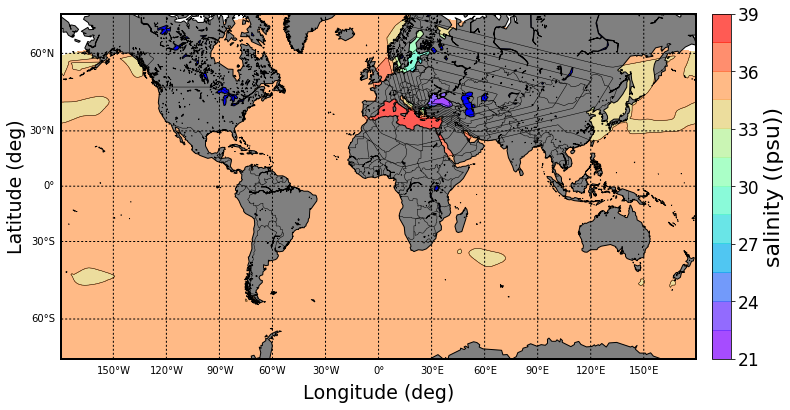

In [11]:
newPlot = plotRaw(['plan'])
fig, ax_out = newPlot.make()
dataset = getData()

dpth = 1500
minlat, maxlat, minlon, maxlon = -70, 70,-180, 180

dataset.get_plan([minlat, maxlat], [minlon, maxlon], [tracer], dpth)
fig, ax_out[0] = newPlot.add_plan(fig, ax_out[0], dataset, tracer, dpth)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:23: SADeprecationWarning: reflect=True is deprecate; please use the reflect() method.


(5500.0, 0)

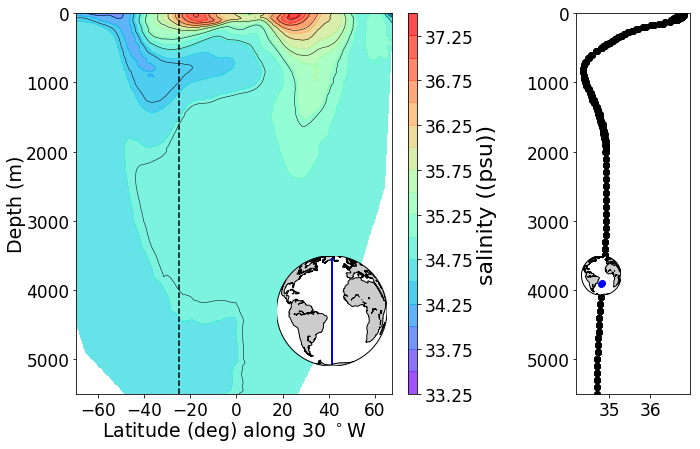

In [12]:
ptlat, ptlon = -25, -30
lineLon = -30
minLat, maxLat = -70, 70
tracer = 'salinity'

newPlot = plotRaw(['section', 'column'])
fig, ax_out = newPlot.make()

dataset = getData()
dataset.get_section('NS_section', lineLon, [minLat, maxLat], [tracer])
# datasest.get_section('EW_section', lineLat, [minLon, maxLon], [tracer])
maxdepth = max(dataset._d)

fig, ax_out[0] = newPlot.add_section(fig, ax_out[0], dataset, tracer)
ax_out[0].axvline(x=ptlat, color='k', linestyle='--')
ax_out[0].set_ylim([maxdepth, 0])

dataset2 = getData()
dataset2.get_column([ptlat, ptlat+2], [ptlon, ptlon+2], [tracer])

fig, ax_out[1] = newPlot.add_column(fig, ax_out[1], dataset2, tracer)

ax_out[1].set_ylim([maxdepth, 0])

